### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
#     print(reference)
    return series, reference

In [2]:
df = pd.read_csv('../data/freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [4]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

df.Gender, GenderRef = SeriesFactorizer(df.Gender)
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

df = df.select_dtypes(exclude=['object'])

df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)

df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + \
                    df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [6]:
print(f"До: {df['ClaimsCount'].unique()}")
df.loc[df.ClaimsCount == 11, 'ClaimsCount'] = 10
print(f"После: {df['ClaimsCount'].unique()}")

До: [ 0.  4.  2.  1.  3.  5.  6.  7.  8.  9. 11.]
После: [ 0.  4.  2.  1.  3.  5.  6.  7.  8.  9. 10.]


Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [7]:
FreqCount = pd.DataFrame(df.groupby('ClaimsCount')['ClaimAmount'].count().reset_index()
                         .rename(columns={'ClaimAmount':'Count'}), 
             columns=['Count'])
FreqCount['Freq'] = FreqCount.index/FreqCount.Count

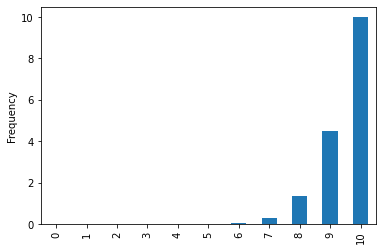

In [8]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [9]:
FreqCount

,Count,Freq
0,104286,0.000000
1,3339,0.000299
2,3529,0.000567
3,2310,0.001299
4,1101,0.003633
5,428,0.011682
6,127,0.047244
7,26,0.269231
8,6,1.333333
9,2,4.500000


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [10]:
df['weight'] = 1
df.loc[df['ClaimsCount']==0, ['weight']] = 0.05

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimsCount'], axis=1), 
                                                    df.ClaimsCount, 
                                                    test_size=0.3, 
                                                    random_state=10)

x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [12]:
xgb_train = xgb.DMatrix(data=x_train.drop(['weight'], axis=1), label=y_train, weight=x_train['weight'])
xgb_valid = xgb.DMatrix(data=x_valid.drop(['weight'], axis=1), label=y_valid)
xgb_test = xgb.DMatrix(data=x_test.drop(['weight'], axis=1), label=y_test)

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [13]:
# Определим границы, в которых будем искать гиперпараметры

space_xgb = {'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
             'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
             'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'num_class': df['ClaimsCount'].unique().size,
             'eval_metric': 'auc',
             'objective': 'multi:softprob',
             'nthread': 4,
             'booster': 'gbtree',
             'tree_method': 'exact',
             'verbosity': 0
            }

In [14]:
def hyperopt_xgb_score(params):
    clf = xgb.XGBClassifier(**params)
    current_score = cross_val_score(clf, x_test, y_test, cv=3).mean()
    return -current_score

In [15]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [16]:
# Оптимизация
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=40)

100%|███████████████████████████████████████████████| 40/40 [44:56<00:00, 67.42s/trial, best loss: -0.9394465670950561]


In [17]:
# Оптимальные гиперпараметры
best_params = space_eval(space_xgb, best)
best_params

{'booster': 'gbtree',
 'colsample_bytree': 0.8,
 'eta': 0.05,
 'eval_metric': 'auc',
 'gamma': 0.9,
 'max_depth': 1,
 'min_child_weight': 2.0,
 'n_estimators': 200,
 'nthread': 4,
 'num_class': 11,
 'objective': 'multi:softprob',
 'subsample': 0.8,
 'tree_method': 'exact',
 'verbosity': 0}

Далее обучим нашу модель с оптимальными параметрами

In [18]:
xgb_multiclass = xgb.train(params=best_params,
                           dtrain=xgb_train,
                           num_boost_round=30,
                           feval=hyperopt_xgb_score,
                           maximize=True,
                           early_stopping_rounds=None,
                           evals_result=None,
                           verbose_eval=False)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [19]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    # Посчитаем предсказанные значения
    class_preds = [range(0, space_xgb['num_class'])[idx] for idx in np.argmax(xgb_multiclass.predict(dfset['dmat']), axis=1)]
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.935850039698293
F1 Score on valid: 0.9375325652752852
F1 Score on test: 0.936899386361005


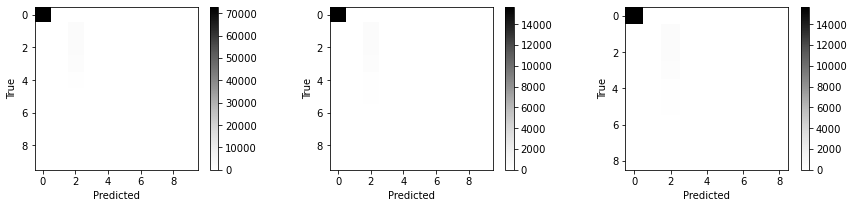

In [20]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'].values,
            [range(0, space_xgb['num_class'])[idx] for idx in np.argmax(xgb_multiclass.predict(dfsets[i]['dmat']), axis=1)])
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

О качестве модели сказать сложно, так как присутствует сильный дизбаланс классов. Более эффективно было бы делать бинарную классификацию (без убытка и с убытком), а убыточные полисы уже предсказывать на количество случаев по полису другой моделью. Несбалансированность классов можно уменьшить с помощью over- и under-sampling'а, можно поэкспериментировать с ADASYN или SMOTE.
Также необходимо добавить экспозицию в веса, так как она напрямую влияет на количество событий по полису.